Part 1: Build a Basic Chatbot

In [2]:
from langchain_groq import ChatGroq
from api_key import llama_key

llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)
respond = llm.invoke("hello")
print(respond.content)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jh9m089wfyqve02jvrgtm0y6` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100695, Requested 6. Please try again in 10m5.962s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
pip install -U langgraph langsmith langchain_anthropic

In [13]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("llama_key")

In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [24]:
from langchain_groq import ChatGroq
from api_key import llama_key

llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [25]:
graph_builder.add_edge(START, "chatbot")

In [26]:
graph_builder.add_edge("chatbot", END)

In [27]:
graph = graph_builder.compile()


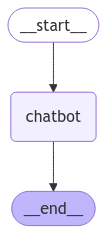

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: It seems like you've provided a code or a string of characters, but I'm not sure what it refers to. Could you please provide more context or information about what this code is for? I'll do my best to help you understand or resolve the issue.
Assistant: It seems like you didn't type anything. Please go ahead and ask your question, and I'll do my best to help.
Goodbye!


Part 2: 🛠️ Enhancing the Chatbot with Tools

In [17]:
_set_env("TAVILY_API_KEY")

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph - LangChain Blog',
  'url': 'https://blog.langchain.dev/langgraph/',
  'content': 'TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. graph.add_edge("tools", "model") The state of this graph by default contains concepts that should be familiar to you if you\'ve used LangChain agents: input, chat_history, intermediate_steps (and agent_outcome to represent the most recent agent outcome)',
  'score': 0.70944256},
 {'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': '[](https://langchain-ai.github.

In [36]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_groq import ChatGroq
from api_key import llama_key

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [37]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [38]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

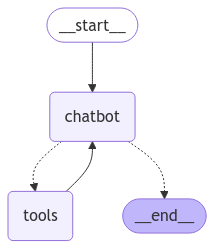

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello. How can I assist you today?
Assistant: It seems like you're asking about a specific node, but I'm not sure which one you're referring to. Could you please provide more context or clarify which type of node you're interested in? For example, are you referring to:

1. A node in a graph or network?
2. A node in a programming context (e.g., Node.js)?
3. A node in a data structure (e.g., a linked list or tree)?
4. A node in a different context (e.g., biology, physics, or another field)?

Please provide more information so I can better understand your question and provide a helpful response.
Goodbye!


Part 3: Adding Memory to the Chatbot

In [40]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [43]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_groq import ChatGroq
from api_key import llama_key

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [45]:
graph = graph_builder.compile(checkpointer=memory)


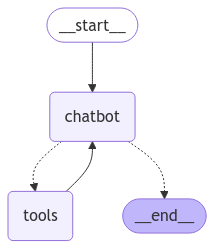

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
config = {"configurable": {"thread_id": "1"}}


In [49]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

It's nice to meet you, Will. Is there something I can help you with or would you like to chat?


In [50]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will.


In [51]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember names or personal information. I'm a text-based AI assistant, and our conversation just started. If you'd like to share your name, I'd be happy to chat with you, though.


In [52]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='40493c3b-5222-498a-bf36-429dc6b2887e'), AIMessage(content="It's nice to meet you, Will. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 286, 'total_tokens': 311, 'completion_time': 0.090909091, 'prompt_time': 0.012989172, 'queue_time': 0.234992423, 'total_time': 0.103898263}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e91e6fbd56', 'finish_reason': 'stop', 'logprobs': None}, id='run-cff98cb0-485c-4def-8e87-3d0c46c30ab4-0', usage_metadata={'input_tokens': 286, 'output_tokens': 25, 'total_tokens': 311}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='09343543-1123-4321-a79e-faa3438a21d4'), AIMessage(content='Yes, your name is Will.', additional_kwargs={}, response_metadata={

Part 4: Human-in-the-loop

In [53]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

from langchain_groq import ChatGroq
from api_key import llama_key

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [54]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

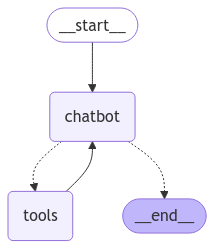

In [55]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_4qfe)
 Call ID: call_4qfe
  Args:
    query: building an AI agent


In [57]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [58]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_4qfe)
 Call ID: call_4qfe
  Args:
    query: building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_zhwn)
 Call ID: call_zhwn
  Args:
    query: LangGraph


Part 5: Customizing State

In [59]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [65]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [63]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_groq import ChatGroq
from api_key import llama_key

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(
    temperature=0,
    groq_api_key=llama_key,
    model_name='llama-3.3-70b-versatile'
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [69]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
print(events)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

<generator object Pregel.stream at 0x7c2810056350>
================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


AssertionError: 

In [70]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


AssertionError: 